In [1]:
import string
import sys
from collections import deque

import pandas as pd
import numpy as np
import altair as alt
alt.renderers.enable('mimetype')

from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm.sklearn import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor



warnings.simplefilter(action="ignore", category=FutureWarning)

In [2]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [3]:
train_df = pd.read_csv("data/train.csv")

In [4]:
train_df.set_index('PassengerId', inplace = True)

In [5]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [7]:
train_df.nunique()

Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64

# EDA

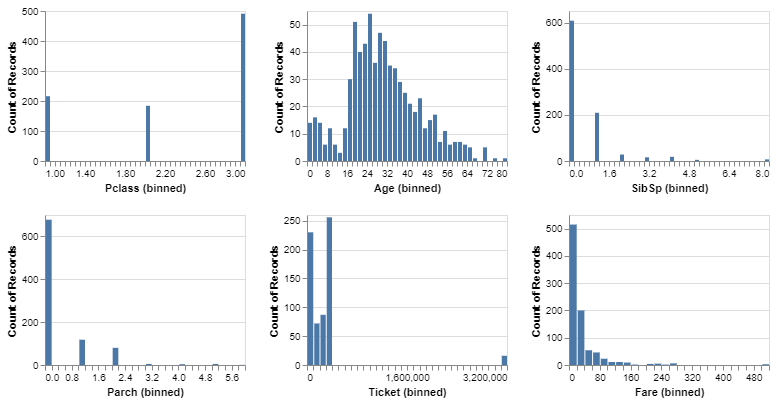

In [8]:
alt.Chart(train_df).mark_bar().encode(
    alt.X(alt.repeat(), type='quantitative', bin=alt.Bin(maxbins=40)),
    y='count()',
).properties(
    width=200,
    height=150
).repeat(
    ['Pclass', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare'],
    columns=3
)

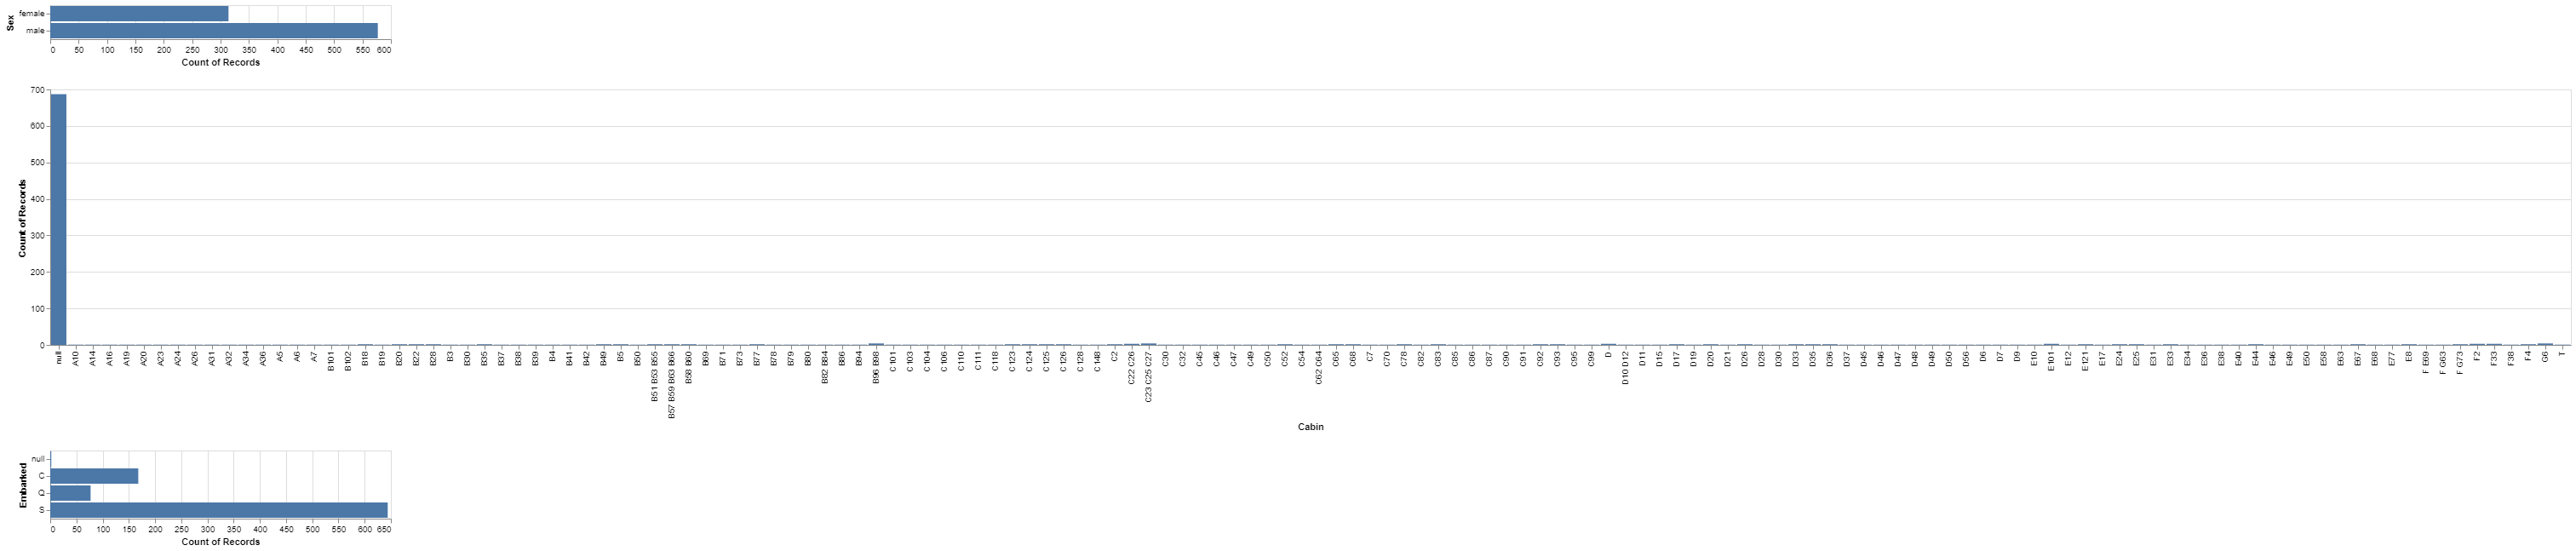

In [9]:
#Sex, Cabin, Embarked

plot_sex = alt.Chart(train_df).mark_bar().encode(
    y='Sex',
    x='count()')
plot_cabin = alt.Chart(train_df).mark_bar().encode(
    x='Cabin',
    y='count()')
plot_embarked = alt.Chart(train_df).mark_bar().encode(
    y='Embarked',
    x='count()')

plot_sex & plot_cabin & plot_embarked

In [10]:
X_train, y_train = train_df.drop(columns=['Survived']), train_df['Survived']

# Feature types

In [11]:
numeric_features = ["Pclass", "Age", "Fare", "SibSp", "Parch"]
binary_features = ["Sex"]
categorical_features = ["Embarked"]
drop_features = ["Name", "Ticket", "Cabin"]       #Ticket, Cabin will be reconsidered later 

In [12]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy='median'), StandardScaler()),
        numeric_features
    ),
    (
        OneHotEncoder(drop="if_binary", dtype=int, sparse=False), 
        binary_features
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(handle_unknown="ignore")
        ), categorical_features
    ),
    ("drop", drop_features)
)

In [13]:
results = {}

In [14]:
pipe_dummy = make_pipeline(ct, DummyClassifier())

In [15]:
results["Dummy"] = mean_std_cross_val_scores(
    pipe_dummy, X_train, y_train, return_train_score=True
)

In [16]:
pd.DataFrame(results)

,Dummy
fit_time,0.010 (+/- 0.001)
score_time,0.005 (+/- 0.001)
test_score,0.616 (+/- 0.003)
train_score,0.616 (+/- 0.001)


# ML Models

In [17]:
pipe_dt = make_pipeline(ct, DecisionTreeClassifier(random_state=123))
pipe_rf = make_pipeline(ct, RandomForestClassifier(random_state=123))
pipe_xgb = make_pipeline(ct, XGBClassifier(random_state=123, verbosity=0, use_label_encoder=False))
pipe_lgbm = make_pipeline(ct, LGBMClassifier(random_state=123))
pipe_catb = make_pipeline(ct, CatBoostClassifier(random_state=123, verbose=0))

In [18]:
models = {
    "decision_tree": pipe_dt,
    "random_forest": pipe_rf,
    "XGBoost": pipe_xgb,
    "LightGBM": pipe_lgbm,
    "CatBoost": pipe_catb
}

In [19]:
for (name, model) in models.items():
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True
    )

In [20]:
pd.DataFrame(results)

,Dummy,decision_tree,random_forest,XGBoost,LightGBM,CatBoost
fit_time,0.010 (+/- 0.001),0.010 (+/- 0.000),0.138 (+/- 0.014),0.064 (+/- 0.003),0.044 (+/- 0.004),1.072 (+/- 0.063)
score_time,0.005 (+/- 0.001),0.004 (+/- 0.000),0.016 (+/- 0.005),0.006 (+/- 0.001),0.006 (+/- 0.000),0.005 (+/- 0.001)
test_score,0.616 (+/- 0.003),0.772 (+/- 0.040),0.804 (+/- 0.023),0.817 (+/- 0.035),0.827 (+/- 0.032),0.825 (+/- 0.030)
train_score,0.616 (+/- 0.001),0.982 (+/- 0.003),0.982 (+/- 0.003),0.971 (+/- 0.003),0.945 (+/- 0.005),0.902 (+/- 0.011)
